In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import get_best_params, agg_dataframe

In [3]:
df = pd.read_csv("../reports/model_sizes/v1.csv.zip")
df_coco = pd.read_csv("../reports/model_sizes/COCOB.csv.zip")
pd.concat([df, df_coco]).to_csv("../reports/model_sizes/v1.csv.zip", index=True)

In [4]:
pd.concat([df, df_coco]).to_csv("../reports/model_sizes/v1.csv.zip", index=False)

In [5]:
# Load results from pre-tuning
df_tune = pd.read_csv("../reports/pretune/prequential.csv.zip")
df_tune["step"] /= 4
df_tune = df_tune.sort_values(by="step")


# Load results form conventional tuning
df_btune = pd.read_csv("../reports/pretune/batch_mode.csv.zip")
df_btune = df_btune[df_btune.n_samples==1000]

# Load results from rest of stream
df_stream = pd.read_csv("../reports/model_sizes/v1.csv.zip")
df_stream["accuracy"] *= 100
sgd_stream = df_stream[df_stream["optimizer"] == "SGD"]
dog_stream = df_stream[df_stream["optimizer"] == "DoG"]

/tmp/ipykernel_1322809/3083418141.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tune = pd.read_csv("../reports/pretune/prequential.csv.zip")
/tmp/ipykernel_1322809/3083418141.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stream = pd.read_csv("../reports/model_sizes/v1.csv.zip")


In [6]:
# Compute expanding mean prequential accuracy
variables = [
    "dataset",
    "n_hidden_layers",
    "n_hidden_units",
    "n_samples",
]
dfs = []
for params, dfg in df_tune.groupby(variables + ["base_lr", "gamma", "seed"]):
    dfg["preq_accuracy"] = dfg["accuracy"].expanding().mean()
    dfs.append(dfg)
df_tune = pd.concat(dfs)
# Get best parameters according to pre-tuning
best_params_tune = get_best_params(
    df_tune,
    params=["base_lr", "gamma"],
    fixed_params=[
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "n_samples",
        "step",
        "seed",
    ],
    metric="preq_accuracy",
).drop(["preq_accuracy", "accuracy"], axis=1)

# Get best parameters according to batch tuning
best_params_btune = get_best_params(
    df_btune,
    params=["base_lr", "gamma"],
    fixed_params=[
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "n_samples",
        "seed",
    ],
    metric="best_val_accuracy",
).drop("best_val_accuracy", axis=1)


# Compute mean accuracy over seeds for stream
sgd_stream = agg_dataframe(
    sgd_stream,
    cols_to_keep=[
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "optimizer",
    ],
)
sgd_stream.columns = [col.split("_mean")[0] for col in sgd_stream.columns]
sgd_stream = sgd_stream[
    [
        "accuracy",
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "optimizer",
    ]
]

# Filter mean stream accuracies by pre-tuned parameters
tuned_stream = best_params_tune.merge(
    sgd_stream,
    on=[
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
    ],
)
tuned_stream["optimizer"] = "Pre-Tuning"

# Filter mean stream accuracies by batch tuned parameters
btuned_stream = best_params_btune.merge(
    sgd_stream,
    on=[
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
    ],
)
btuned_stream["optimizer"] = "Batch Tuning"


# Get best lrs according to stream results
oracle_stream = get_best_params(
    sgd_stream,
    params=["base_lr", "gamma"],
    fixed_params=[
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
    ],
    metric="accuracy",
)
oracle_stream["optimizer"] = "Best LR"


dog_stream.loc[:, "base_lr"] = dog_stream["lr_norm"]
dog_stream.loc[:, "step"] = 0

stream = pd.concat([tuned_stream, btuned_stream, dog_stream, oracle_stream])
# Get deviations from optimal learning rate
results = []
for config, dfc in stream.groupby(
    ["n_hidden_layers", "n_hidden_units", "dataset"]
):
    best_lr = dfc[dfc.optimizer == "Best LR"]["base_lr"].item()
    dfc["delta_best_lr"] = np.abs(dfc["base_lr"] - best_lr)
    results.append(dfc)
stream = pd.concat(results)
stream = stream.fillna(0)
stream = agg_dataframe(
    stream,
    cols_to_keep=[
        "gamma",
        "dataset",
        "n_samples",
        "n_hidden_layers",
        "n_hidden_units",
        "optimizer",
        "step",
        "seed",
    ],
)
stream.columns = [col.split("_mean")[0] for col in stream.columns]

In [7]:
from tools.base import DATASETS_SYNTH


real_streams = stream[~stream.dataset.isin(DATASETS_SYNTH)]
stream_mean = agg_dataframe(
    real_streams,
    cols_to_keep=[
        "n_hidden_layers",
        "n_hidden_units",
        "n_samples",
        "step",
        "optimizer",
    ],
)

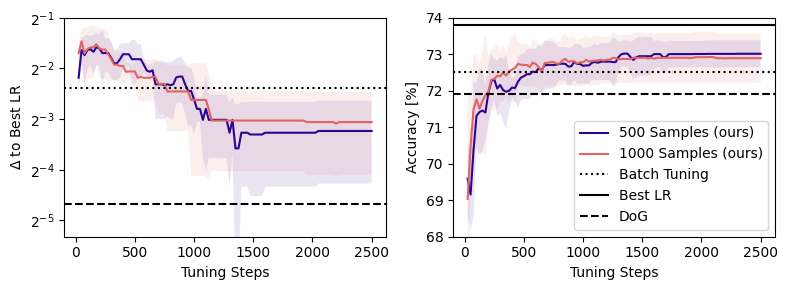

In [8]:
colors = {500: "#2C0493", 1000: "#E06461"}
linestyles = {"DoG": "dashed", "Best LR": "solid", "Batch Tuning": "dotted"}
vars_y = ["delta_best_lr", "accuracy"]
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
dfp = stream_mean[
    (stream_mean["n_hidden_layers"] == 1) & (stream_mean["n_hidden_units"] == 64)
]
df_tune = dfp[(dfp["optimizer"] == "Pre-Tuning")]
for ax, var_y in zip(axs, vars_y):
    for n_samples, df_n_samples in df_tune.groupby("n_samples"):
        steps = df_n_samples["step"]
        scores = df_n_samples[f"{var_y}_mean"]
        stds = df_n_samples[f"{var_y}_std"]
        color = colors[n_samples]
        ax.plot(
            steps,
            scores,
            c=color,
            label=f"{int(n_samples)} Samples (ours)",
        )
        ax.fill_between(
            steps,
            scores - stds,
            scores + stds,
            color=color,
            edgecolor="none",
            alpha=0.1,
        )
    for baseline, df_base in dfp.groupby("optimizer"):
        if baseline == "Pre-Tuning":
            continue
        ax.axhline(
            df_base[f"{var_y}_mean"].item(),
            label=baseline,
            color="black",
            linestyle=linestyles[baseline],
        )
    ax.set_xlabel("Tuning Steps")

axs[0].set_yscale("log", base=2)
axs[0].set_ylim([0.025, 0.5])
axs[1].set_ylim([68, 74])
axs[0].set_ylabel(r"$\Delta$ to Best LR")
axs[1].set_ylabel("Accuracy [%]")
fig.tight_layout()
ax.legend()
fig.savefig("../pub/figures/pretune_1x64_acc_lr_exp_schedule.pdf")

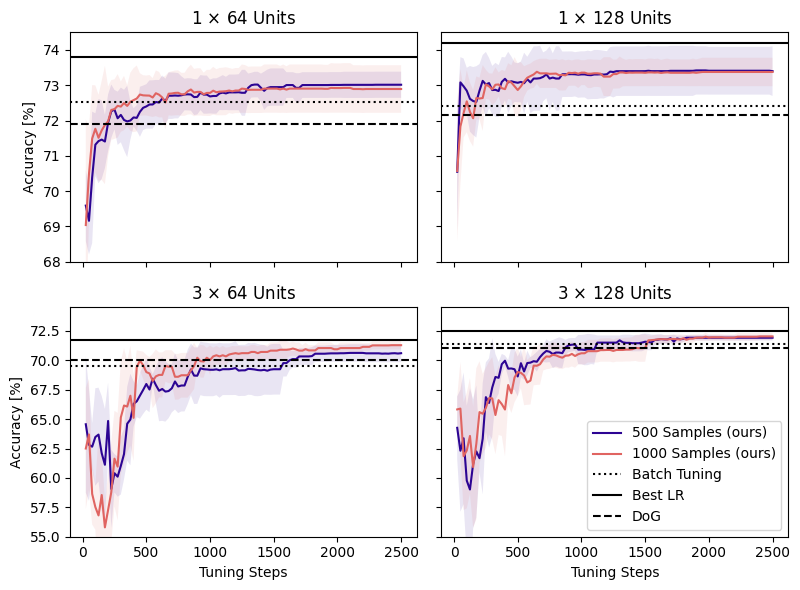

In [9]:
colors = {500: "#2C0493", 1000: "#E06461"}
linestyles = {"DoG": "dashed", "Best LR": "solid", "Batch Tuning": "dotted"}
var_y = "accuracy"
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharey="row", sharex=True)
dfp = stream_mean
for row_idx, (n_hidden_layers, df_row) in enumerate(dfp.groupby("n_hidden_layers")):
    axs[row_idx, 0].set_ylabel("Accuracy [%]")
    for col_idx, (n_hidden_units, df_cell) in enumerate(
        df_row.groupby("n_hidden_units")
    ):
        ax = axs[row_idx, col_idx]
        ax.set_title(r"{} $\times$ {} Units".format(n_hidden_layers, n_hidden_units))
        df_tune = df_cell[df_cell.optimizer == "Pre-Tuning"]
        for n_samples, df_n_samples in df_tune.groupby("n_samples"):
            steps = df_n_samples["step"]
            scores = df_n_samples[f"{var_y}_mean"]
            stds = df_n_samples[f"{var_y}_std"]
            color = colors[n_samples]
            ax.plot(
                steps,
                scores,
                c=color,
                label=f"{int(n_samples)} Samples (ours)",
            )
            ax.fill_between(
                steps,
                scores - stds,
                scores + stds,
                color=color,
                edgecolor="none",
                alpha=0.1,
            )
        for baseline, df_base in df_cell.groupby("optimizer"):
            if baseline == "Pre-Tuning" or (
                baseline == "DoG" and var_y == "delta_best_lr"
            ):
                continue
            ax.axhline(
                df_base[f"{var_y}_mean"].item(),
                label=baseline,
                color="black",
                linestyle=linestyles[baseline],
            )

axs[1, 0].set_xlabel("Tuning Steps")
axs[0, 0].set_ylim([68, 74.5])
axs[1, 0].set_ylim([55, 74.5])
axs[1, 1].set_xlabel("Tuning Steps")
fig.tight_layout()
ax.legend()
fig.savefig("../pub/figures/pretune_architectures_exp_schedule.pdf")

In [14]:
data_table

,gamma,dataset,n_samples,n_hidden_layers,n_hidden_units,optimizer,step,seed,base_lr,base_lr_std,...,best_epoch,best_epoch_std,scheduler,scheduler_std,subsample,subsample_std,lr_norm,lr_norm_std,delta_best_lr,delta_best_lr_std
240,0.999756,Agrawal,500.0,1,64,Pre-Tuning,2000.0,2.0,0.125,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.000,NaN
241,0.999756,Agrawal,500.0,1,64,Pre-Tuning,2000.0,3.0,0.250,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.125,NaN
242,0.999756,Agrawal,500.0,1,64,Pre-Tuning,2000.0,4.0,0.125,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.000,NaN
629,0.999756,Agrawal,500.0,1,128,Pre-Tuning,2000.0,0.0,0.125,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.125,NaN
630,0.999756,Agrawal,500.0,1,128,Pre-Tuning,2000.0,1.0,0.125,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531835,1.000000,Covertype,NaN,3,128,COCOB,99600.0,4.0,100.000,NaN,...,NaN,NaN,NaN,NaN,1000.0,NaN,1315.542170,NaN,NaN,NaN
3531836,1.000000,Covertype,NaN,3,128,COCOB,99700.0,4.0,100.000,NaN,...,NaN,NaN,NaN,NaN,1000.0,NaN,4.467619,NaN,NaN,NaN
3531837,1.000000,Covertype,NaN,3,128,COCOB,99800.0,4.0,100.000,NaN,...,NaN,NaN,NaN,NaN,1000.0,NaN,1365.183931,NaN,NaN,NaN
3531838,1.000000,Covertype,NaN,3,128,COCOB,99900.0,4.0,100.000,NaN,...,NaN,NaN,NaN,NaN,1000.0,NaN,1350.567104,NaN,NaN,NaN


In [15]:
# Make tables
from utils import *

data_cocob = df_stream[df_stream.optimizer == "COCOB"]
data_cocob['n_samples'] = 0
data_table = stream[~(stream.optimizer == "Pre-Tuning") | (stream.step == 2000)]
data_table = pd.concat([data_table, data_cocob])
dataset_means = agg_dataframe(
    data_table, cols_to_keep=["n_samples", "dataset", "optimizer"]
).fillna(10)
dataset_means["optimizer"] = (
    dataset_means["optimizer"] + "@" + dataset_means["n_samples"].astype(str)
)
datasets = [
    "Agrawal",
    "LED",
    "RBF abrupt",
    "RBF incr.",
    "Covertype",
    "Electricity",
    "Insects abrupt",
    "Insects gradual",
    "Insects incr.",
]

def make_tables(df, datasets, index):
    columns = [(dataset, "accuracy") for dataset in datasets]
    df = df[df["dataset"].isin(datasets)]
    table = df[["dataset", index, "accuracy_mean", "accuracy_std"]]
    table = col_to_header(table, "dataset", index=[index])
    mask_best = get_best_within_std(table, metrics=columns, modes="max")
    table = merge_mean_std(table, columns, formats="{:.2f}")
    style = table.style
    style = apply_style_attribute(style, mask=mask_best)
    style.to_latex(f"../pub/tables/lr_tuning.tex", hrules=True)
    return style


make_tables(dataset_means, datasets=datasets, index="optimizer")

/tmp/ipykernel_1322809/3909510571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cocob['n_samples'] = 0


,Agrawal,LED,RBF abrupt,RBF incr.,Covertype,Electricity,Insects abrupt,Insects gradual,Insects incr.
,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy
optimizer,,,,,,,,,
Batch Tuning@1000.0,81.09±1.34,66.67±3.28,91.89±.39,72.51±1.63,82.41±.61,72.86±.76,69.81±2.18,73.91±.64,58.27±2.21
Best LR@0.0,83.70±10.00,73.95±10.00,93.84±10.00,81.52±10.00,83.14±10.00,74.15±10.00,71.98±10.00,75.28±10.00,60.75±10.00
COCOB@0.0,83.71±.25,74.34±.09,95.29±.24,78.59±.38,82.96±.19,84.57±.08,75.39±.10,77.62±.08,64.02±.11
DoG@0.0,82.06±.52,73.71±.11,91.36±.46,77.63±1.24,82.56±.15,70.47±.40,70.59±.10,73.92±.11,58.83±.07
Pre-Tuning@1000.0,82.56±.25,73.30±.00,92.18±.38,72.98±.44,80.80±1.05,73.37±.34,71.81±.06,75.17±.05,60.33±.28
Pre-Tuning@500.0,82.01±.32,73.26±.03,92.36±.03,73.19±.31,80.25±1.86,73.34±.45,71.81±.04,75.22±.08,60.55±.10
